In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
import thinkplot
import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Quiz 2 - Get Hyp'

<ul>
<li> Use this as a starting point for your work, but answer the questions on Moodle. 
<li> Publish this to your GitHub and submit the link in the question on Moodle. 
</ul>

## Potentially Useful Information

#### Data Dictionary
<ul>
<li>credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
<li>purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
<li>int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
<li>installment: The monthly installments owed by the borrower if the loan is funded.
<li>log.annual.inc: The natural log of the self-reported annual income of the borrower.
<li>dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
<li>fico: The FICO credit score of the borrower.
<li>days.with.cr.line: The number of days the borrower has had a credit line.
<li>revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
<li>revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
<li>inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
<li>not.fully.paid: 1 if the borrower failed to repay their loan, 0 if they have not failed
</ul>

#### FICO Score Groups

![FICO](fico_range.png "FICO Ranges")

#### Note on ANOVA - Might be Useful, Might Not

> @JeremyMiles is right. First, there's a rule of thumb that the ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. Furthermore, the general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power. Since you have a significant effect anyway, there is less reason to be concerned here. 
- https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance

In [2]:
# Please don't alter this part. 
df = pd.read_csv("loan_data.csv")
df.drop(columns={"delinq.2yrs", "pub.rec"}, inplace=True)
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,0


### Visualize/Explore Data - If You Want, You Do You

## Solutions

In [4]:
df_paid=df[df['not.fully.paid']==0]
df_npaid=df[df['not.fully.paid']==1]
dp_fico=df_paid['fico']
dn_fico=df_npaid['fico']

In [6]:
print(dp_fico.mean(), dp_fico.median())
print(dn_fico.mean(), dn_fico.median())

713.3269111249223 707.0
697.8284409654273 692.0


In [7]:
stat, pval=ss.ttest_ind(dp_fico, dn_fico)
pval

4.227100096647354e-49

In [9]:
df_wor=df[df['credit.policy']==1]
df_nwor=df[df['credit.policy']==0]
dw_fico=df_wor['fico']
dnw_fico=df_nwor['fico']
print(dw_fico.mean(), dw_fico.median())
print(dnw_fico.mean(), dnw_fico.median())

717.3560311284047 712.0
683.978051391863 682.0


In [10]:
stat, pval=ss.ttest_ind(dw_fico, dnw_fico)
pval

2.6100416830751396e-271

In [18]:
dw_in=df_wor['log.annual.inc']
dnw_in=df_nwor['log.annual.inc']
print(dw_in.mean(), dw_in.median())
print(dnw_in.mean(), dnw_in.median())

10.942680001295294 10.93310697
10.888519880012797 10.89673933


In [19]:
stat, pval=ss.ttest_ind(dw_in, dnw_in)
pval

0.0006337324172012597

In [22]:
from statsmodels.stats.power import TTestPower
powerTest = TTestPower()
ces = thinkstats2.CohenEffectSize(dw_in, dnw_in)
alpha = .05
nobs = dw_in.count() + dnw_in.count()
pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces

(1.0, 0.08813984185782714)

In [23]:
pow2 = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow2, ces

(1.0, 0.08813984185782714)

In [24]:
#Calculate n
n = powerTest.solve_power(ces, power=.85, nobs=None, alpha=alpha)
n

1157.6455504969408

In [25]:
np.exp(df['log.annual.inc']).mean()

68402.03071015503

In [26]:
df['real.income']=np.exp(df['log.annual.inc'])

In [27]:
df['real.income'].skew(), df['days.with.cr.line'].skew(),df['fico'].skew()

(9.59354898996782, 1.1557482270969546, 0.4712597399323796)

In [60]:
df_poor=df[(df['fico'] >= 300)& (df['fico'] <= 579)]
df_fair=df[(df['fico'] >= 580)& (df['fico'] <= 669)]
df_good=df[(df['fico'] >= 670)& (df['fico'] <= 739)]
df_vgood=df[(df['fico'] >= 740)& (df['fico'] <= 799)]
df_exceptional=df[(df['fico'] >= 800)& (df['fico'] <= 850)]

In [61]:
df_poor.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,real.income
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
varStat, varP = ss.levene(
               df['real.income'][(df['fico'] >= 580)& (df['fico'] <= 699)],
               df['real.income'][(df['fico'] >= 670)& (df['fico'] <= 739)],
               df['real.income'][(df['fico'] >= 740)& (df['fico'] <= 799)],
               df['real.income'][(df['fico'] >= 800)& (df['fico'] <= 850)])
varP

9.82369278851959e-06

In [ ]:
df_

In [63]:
len(df_poor)/len(df),len(df_fair)/len(df), len(df_good)/len(df), len(df_vgood)/len(df), len(df_exceptional)/len(df)

(0.0,
 0.14000835247442053,
 0.6271664230528294,
 0.21768636458550847,
 0.015138859887241595)

In [50]:
df_exceptional.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,real.income
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,1.450000e+02
mean,0.937931,0.092488,358.700621,11.218767,5.541586,807.310345,7195.279598,16486.358621,5.691034,0.710345,0.068966,9.658113e+04
std,0.242117,0.019249,231.932692,0.675504,5.338429,5.471539,2856.623487,43148.717154,10.598027,1.160204,0.254274,1.100116e+05
min,0.000000,0.070500,31.050000,9.210340,0.000000,802.000000,3216.958333,0.000000,0.000000,0.000000,0.000000,1.000000e+04
25%,1.000000,0.077400,180.190000,10.778956,0.890000,802.000000,4800.000000,255.000000,0.700000,0.000000,0.000000,4.800000e+04
50%,1.000000,0.085900,312.220000,11.225243,3.720000,807.000000,6750.041667,1576.000000,3.100000,0.000000,0.000000,7.500000e+04
75%,1.000000,0.106200,481.420000,11.654425,8.930000,812.000000,8580.041667,5390.000000,7.200000,1.000000,0.000000,1.152000e+05
max,1.000000,0.191300,918.020000,13.997832,20.400000,827.000000,16259.041670,269726.000000,95.600000,6.000000,1.000000,1.200000e+06


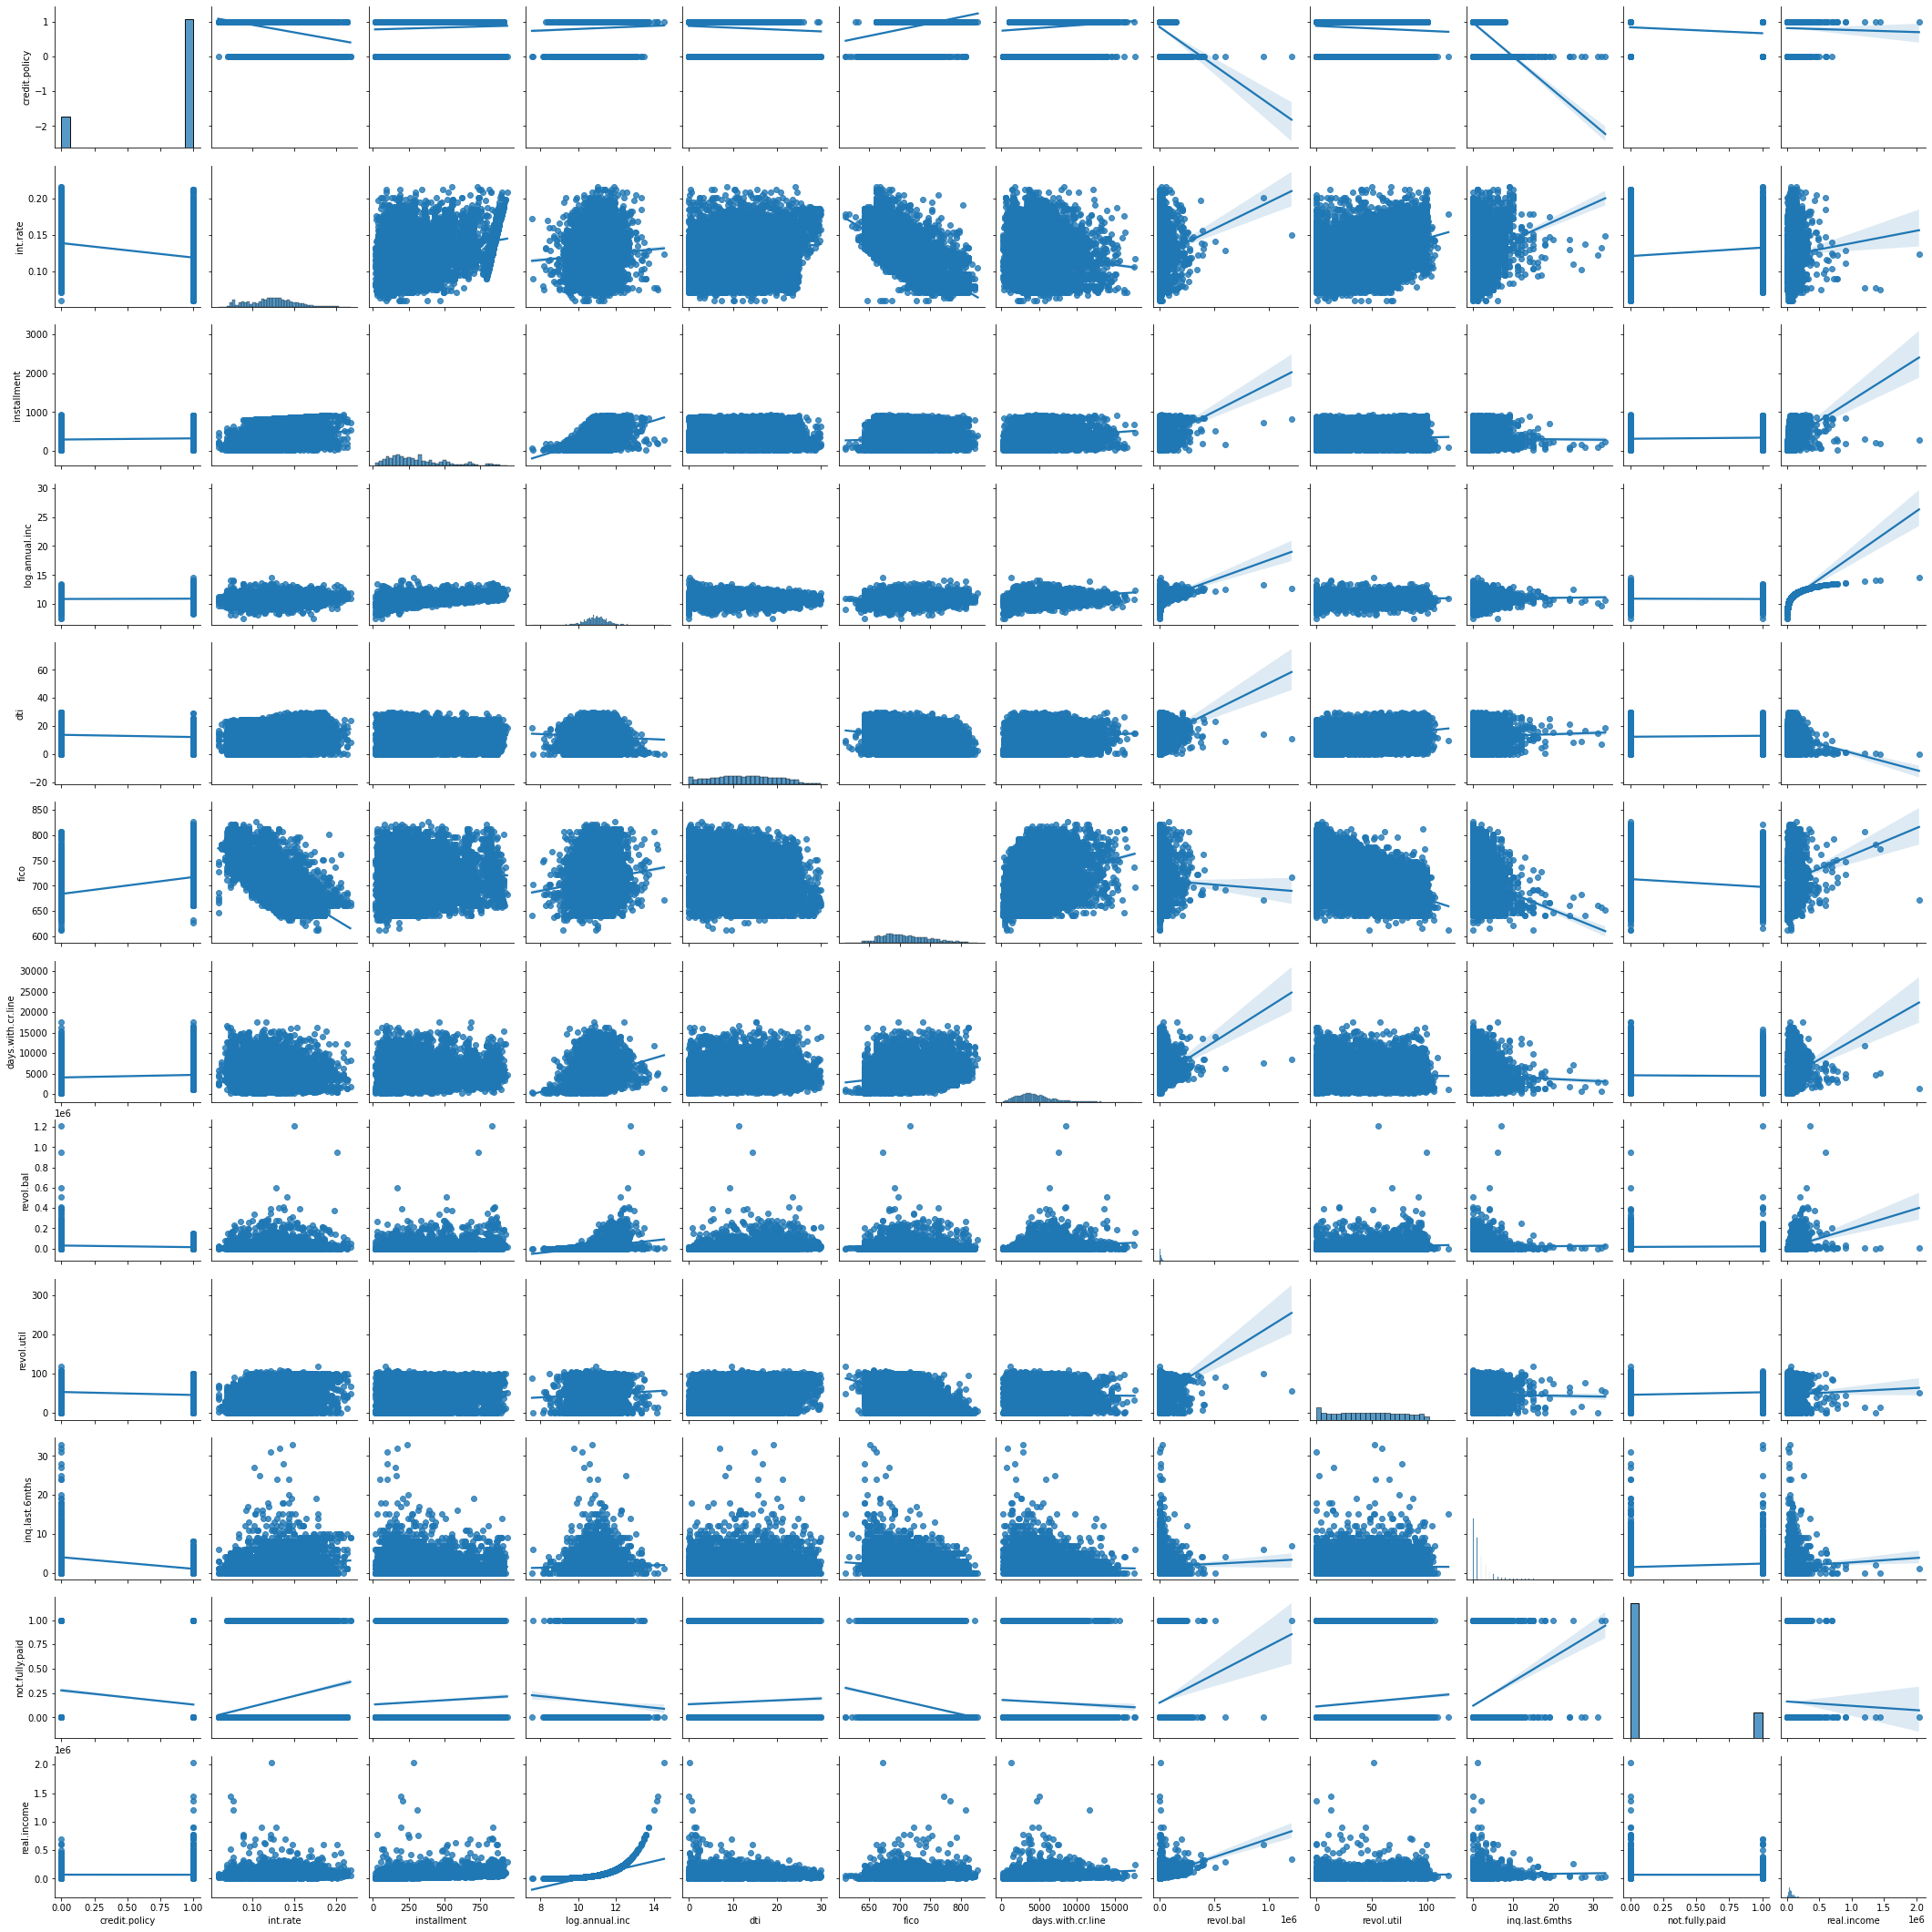

In [64]:
sns.pairplot(df, dropna=True, kind="reg")
plt.show()

In [65]:
drg2 = df.apply(pd.to_numeric, errors='coerce')
drg2 = df.corr()
drg2.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,not.fully.paid,real.income
credit.policy,1.000000,-0.294089,0.058770,0.034906,-0.090901,0.348319,0.099026,-0.187518,-0.104095,-0.535511,-0.158119,-0.008860
int.rate,-0.294089,1.000000,0.276140,0.056383,0.220006,-0.714821,-0.124022,0.092527,0.464837,0.202780,0.159552,0.039003
installment,0.058770,0.276140,1.000000,0.448102,0.050202,0.086039,0.183297,0.233625,0.081356,-0.010419,0.049955,0.312877
log.annual.inc,0.034906,0.056383,0.448102,1.000000,-0.054065,0.114576,0.336896,0.372140,0.054881,0.029171,-0.033439,0.776930
dti,-0.090901,0.220006,0.050202,-0.054065,1.000000,-0.241191,0.060101,0.188748,0.337109,0.029189,0.037362,-0.109705


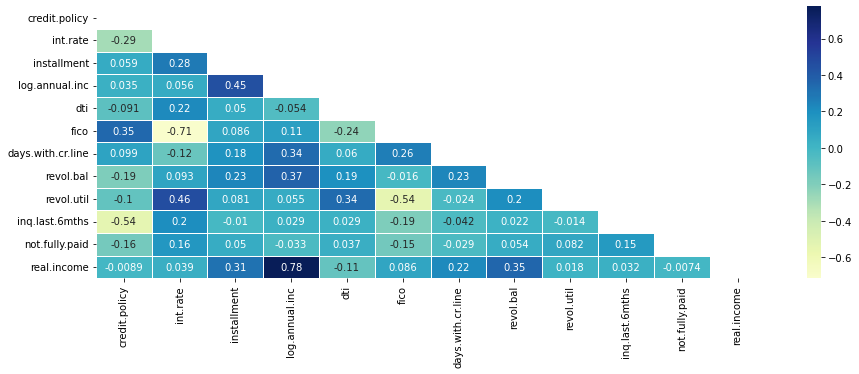

In [66]:
mask = np.triu(np.ones_like(drg2, dtype=bool))
sns.heatmap(drg2, center=0, linewidths=.5, annot=True, cmap="YlGnBu", yticklabels=True, mask=mask)
plt.show()